### Welcome to Group 2's MED263 tutorial on jointly analyzing scRNA-seq and CITE-seq data from different donors.

**This is a Google Colab version!!**

In this notebook we:
1) Preprocess both datasets.
2) Integrate the two datasets.
3) Impute protein expression levels on the scRNA-seq using the joint embedding.
4) Plot key protein and RNA interactions.

First of all, make sure that you:
1. Create a folder named MED263_GROUP2 directly inside your MyDrive. You can then access this folder via address "/content/drive/MyDrive/MED263_GROUP2".
2. Upload this final_project_local_final.ipynb to the MED263_GROUP2 folder.
3. Click Runtime -> Change runtime type -> for Hardware accelerator, select T4 GPU.

In [1]:
#Run this to mount your drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#Run this to install packages. Ignore the colab pandas version error.
!pip install pandas==2.1.1
!pip install git+https://github.com/maximilian-heeg/UCell.git
!pip install scanpy
!pip install numpy
!pip install scvi-tools
!pip install scrublet
!pip install --upgrade setuptools
!pip install mygene

  Cloning https://github.com/maximilian-heeg/UCell.git to /tmp/pip-req-build-5gfvce54
  Running command git clone --filter=blob:none --quiet https://github.com/maximilian-heeg/UCell.git /tmp/pip-req-build-5gfvce54
  Resolved https://github.com/maximilian-heeg/UCell.git to commit 3d291220bb5aa3fb19b1676a27d6cf12685cc300
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [3]:
import os
import scanpy as sc
import numpy as np
import pandas as pd
from scipy.spatial import KDTree
import seaborn as sns
import matplotlib.pyplot as plt
import ucell
import mygene
import pkg_resources

In [4]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [5]:
# run this block to check that your installation is successful

required_packages = {
    'numpy': '>=1.25.0',
    'pandas': '>=1.5.3',
    'scanpy': '>=1.9.8',
    'scrublet': '>=0.2.3',
    'scvi-tools': '>=1.1.2',
    'matplotlib': '>=3.7.1',
    'ucell': '>=0.1',
    'seaborn': '>=0.13.0',
    'mygene': '>=3.2.2',
}

for package, version_range in required_packages.items():
    try:
        installed_version = pkg_resources.get_distribution(package).version
        version_requirement = pkg_resources.Requirement.parse(f"{package}{version_range}")
        assert pkg_resources.parse_version(installed_version) in version_requirement, \
            f"{package} version must be within {version_range}, found version {installed_version}"
    except pkg_resources.DistributionNotFound:
        assert False, f"{package} is not installed."

print("All required packages are installed and within the specified version ranges.")

All required packages are installed and within the specified version ranges.


In [6]:
#This block bypass the bug that leidenalg not installed on colab
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding
!pip install leidenalg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 22.3 MB/s eta 0:00:00


 ##### Read in PMBC3k data
 - This is scRNA-seq data from 3k peripheral blood mononuclear cells (PBMCs) from a healthy donor.

In [7]:
!mkdir "/content/drive/MyDrive/MED263_GROUP2/data"

In [8]:
!wget http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz -O "/content/drive/MyDrive/MED263_GROUP2/data/pbmc3k_filtered_gene_bc_matrices.tar.gz"

--2024-03-12 04:27:21--  http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz
Resolving cf.10xgenomics.com (cf.10xgenomics.com)... 104.18.1.173, 104.18.0.173, 2606:4700::6812:1ad, ...
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|104.18.1.173|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz [following]
--2024-03-12 04:27:21--  https://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|104.18.1.173|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7621991 (7.3M) [application/x-tar]
Saving to: ‘/content/drive/MyDrive/MED263_GROUP2/data/pbmc3k_filtered_gene_bc_matrices.tar.gz’

/content/drive/MyDr 100%[===================>]   7.27M  --.-KB/s    in 0.1s    

2024-03-12 04:27:21 (57.2 MB/s) 

In [9]:
!cd "/content/drive/MyDrive/MED263_GROUP2/data"; tar -xzf pbmc3k_filtered_gene_bc_matrices.tar.gz

In [10]:
#read in pbmc3k data
pbmc3k = sc.read_10x_mtx(
    "/content/drive/MyDrive/MED263_GROUP2/data/filtered_gene_bc_matrices/hg19/",  # the directory with the `.mtx` file
    var_names="gene_symbols",  # use gene symbols for the variable names (variables-axis index)
    cache=True,  # write a cache file for faster subsequent reading
)

Lets look at our data briefly to see what we are working with!

First we need to create 2 observations, n_counts (number of reads per cell) and n_genes (number of genes per cell).

In [11]:
# create n_counts and n_genes
pbmc3k.obs['n_counts'] = pbmc3k.X.sum(1)
pbmc3k.obs['n_genes'] = (pbmc3k.X > 0).sum(1)

In [12]:
pbmc3k.obs.head() #look at the data

,n_counts,n_genes
AAACATACAACCAC-1,2421.0,781
AAACATTGAGCTAC-1,4903.0,1352
AAACATTGATCAGC-1,3149.0,1131
AAACCGTGCTTCCG-1,2639.0,960
AAACCGTGTATGCG-1,981.0,522


Each row represents a singular cell, and here we can see the number of reads and number of genes for each cell.

Using .head() we only look at the first 5 observations, so lets see how big our adata object actually is.

In [13]:
pbmc3k.shape

(2700, 32738)

To get a better sense of the distribution of n_counts and n_genes, we can visualize using violin plots.

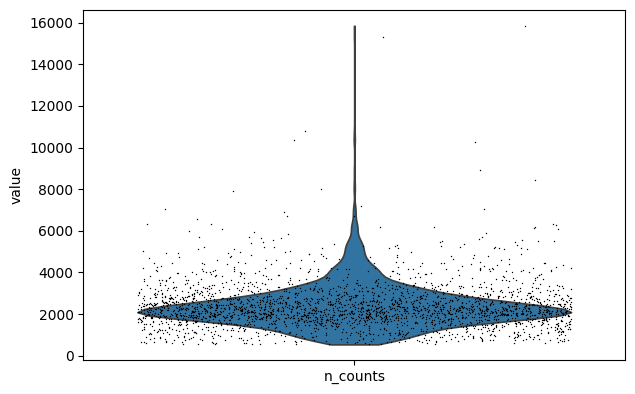

In [14]:
sc.pl.violin(pbmc3k, keys = 'n_counts',jitter=0.4) #make a violin plot of counts

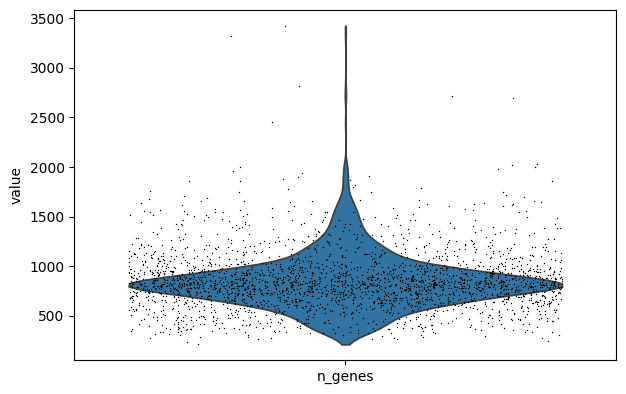

In [15]:
sc.pl.violin(pbmc3k, keys = 'n_genes',jitter=0.4) #violin plot of genes

Now we want to filter the data to get rid of poor reads.

To start, cells with high expression of mitochondrial are probably dead cells and should be filtered out.

First, we need to make a list of genes that are mitochondrial.

In [16]:
mito_genes = pbmc3k.var_names.str.startswith('MT-') #create a list of genes that are mitochondrial

In [17]:
pbmc3k.var["mito"] = pbmc3k.var_names.str.startswith("MT-") #create a variable saying if genes are mitochondrial

In [18]:
sc.pp.calculate_qc_metrics(pbmc3k, qc_vars=["mito"], inplace=True)

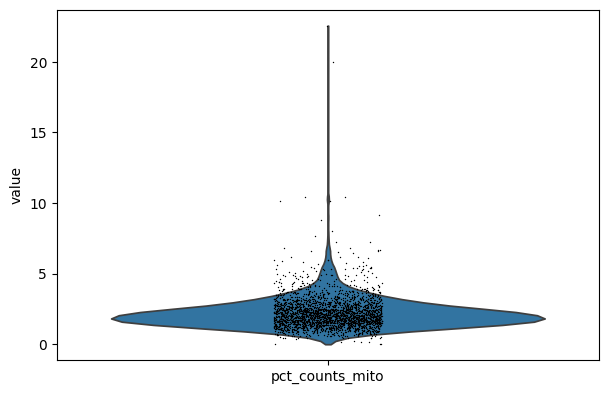

In [19]:
sc.pl.violin(pbmc3k, 'pct_counts_mito') #see what the mito percent looks like

In [20]:
pbmc3k = pbmc3k[pbmc3k.obs.pct_counts_mito < 5, :]

Next we'll filter out cells with exceptionally low or high gene counts, and genes that are expressed in < 5 cells.

In [21]:
sc.pp.filter_cells(pbmc3k, min_genes = 100) #filter out cells with < 100 genes
sc.pp.filter_cells(pbmc3k, max_genes = 3000) #filter out possible doublets
sc.pp.filter_genes(pbmc3k, min_cells=5) #filter out genes with expressed in< 5 cells

/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_simple.py:139: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number


Next we want to normalize the data to account for cell-to-cell differences such as read depth. This will allow us to do accurate differential expression analysis.

In [22]:
pbmc3k.layers["counts"] = pbmc3k.X.copy() #make a copy before normalizing

In [23]:
sc.pp.normalize_per_cell(pbmc3k) #normalize for total counts per cell
sc.pp.log1p(pbmc3k) # log transform

We will also filter for highly variable genes, as these are likely to be biologically relevant.

In [24]:
sc.pp.highly_variable_genes(pbmc3k, min_mean=0.01, max_mean=5, min_disp=0.2) #make a variable that says if the gene is highly variable

In [25]:
pbmc3k.var.highly_variable.sum() #see how many highly variable genes there are

2132

Now we want to save this file to be used for integration.

In [26]:
pbmc3k.write("/content/drive/MyDrive/MED263_GROUP2/data/pbmc3k_preprocessed.h5ad") #write the file as a h5ad to working directory

 ##### Read in PMBC5k data
 - This is CITE-seq data from 5k peripheral blood mononuclear cells (PBMCs) from a healthy donor.

 CITE-seq measures both surface protein and RNA expression in single cells. In this dataset, 32 proteins were quantified.

In [27]:
!wget http://cf.10xgenomics.com/samples/cell-exp/3.1.0/5k_pbmc_protein_v3_nextgem/5k_pbmc_protein_v3_nextgem_filtered_feature_bc_matrix.h5 -O "/content/drive/MyDrive/MED263_GROUP2/data/5k_pbmc_protein_v3_nextgem_filtered_feature_bc_matrix.h5"

--2024-03-12 04:28:10--  http://cf.10xgenomics.com/samples/cell-exp/3.1.0/5k_pbmc_protein_v3_nextgem/5k_pbmc_protein_v3_nextgem_filtered_feature_bc_matrix.h5
Resolving cf.10xgenomics.com (cf.10xgenomics.com)... 104.18.0.173, 104.18.1.173, 2606:4700::6812:ad, ...
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|104.18.0.173|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cf.10xgenomics.com/samples/cell-exp/3.1.0/5k_pbmc_protein_v3_nextgem/5k_pbmc_protein_v3_nextgem_filtered_feature_bc_matrix.h5 [following]
--2024-03-12 04:28:10--  https://cf.10xgenomics.com/samples/cell-exp/3.1.0/5k_pbmc_protein_v3_nextgem/5k_pbmc_protein_v3_nextgem_filtered_feature_bc_matrix.h5
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|104.18.0.173|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18083112 (17M) [binary/octet-stream]
Saving to: ‘/content/drive/MyDrive/MED263_GROUP2/data/5k_pbmc_protein_v3_nextgem_filtered_feature

In [28]:
pbmc5k = sc.read_10x_h5("/content/drive/MyDrive/MED263_GROUP2/data/5k_pbmc_protein_v3_nextgem_filtered_feature_bc_matrix.h5", gex_only=False)
pbmc5k.var_names_make_unique() #make variable names unique
pbmc5k.layers["counts"] = pbmc5k.X.copy() # make a copy like we did for pbmck3
pbmc5k

/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 5527 × 33570
    var: 'gene_ids', 'feature_types', 'genome'
    layers: 'counts'

In [29]:
#filter for number of genes
sc.pp.filter_genes(pbmc5k, min_counts=1)

In [30]:
pbmc5k.var["feature_types"].value_counts() #see what the observations are

feature_types
Gene Expression     21421
Antibody Capture       32
Name: count, dtype: int64

Now we are going to make 2 separate objects, one with RNA data and one with protein data.

In [31]:
pbmc5k_protein = pbmc5k[:, pbmc5k.var["feature_types"] == "Antibody Capture"].copy()
pbmc5k_rna = pbmc5k[:, pbmc5k.var["feature_types"] == "Gene Expression"].copy()

We need to filter the rna and protein data, starting with rna.

In [32]:
pbmc5k_rna

AnnData object with n_obs × n_vars = 5527 × 21421
    var: 'gene_ids', 'feature_types', 'genome', 'n_counts'
    layers: 'counts'

In [33]:
sc.pp.filter_genes(pbmc5k_rna, min_counts=5) #filter out genes that are present in less than 5 cells

In [34]:
pbmc5k_rna.var["mito"] = pbmc5k_rna.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(pbmc5k_rna, qc_vars=["mito"], inplace=True)

In [35]:
pbmc5k_rna

AnnData object with n_obs × n_vars = 5527 × 17097
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito'
    var: 'gene_ids', 'feature_types', 'genome', 'n_counts', 'mito', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'counts'

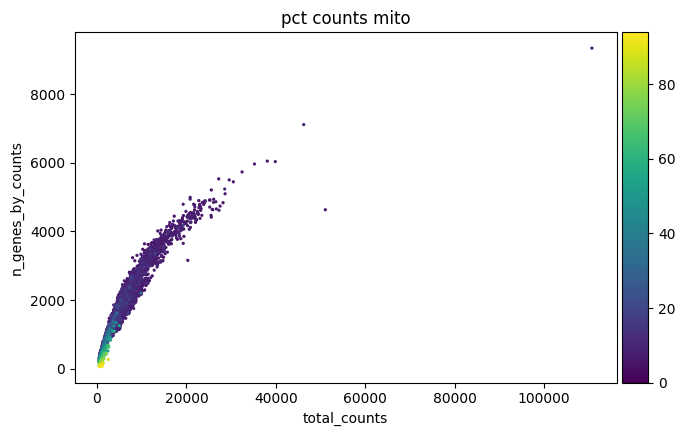

In [36]:
sc.pl.scatter(pbmc5k_rna, "total_counts", "n_genes_by_counts", color="pct_counts_mito")

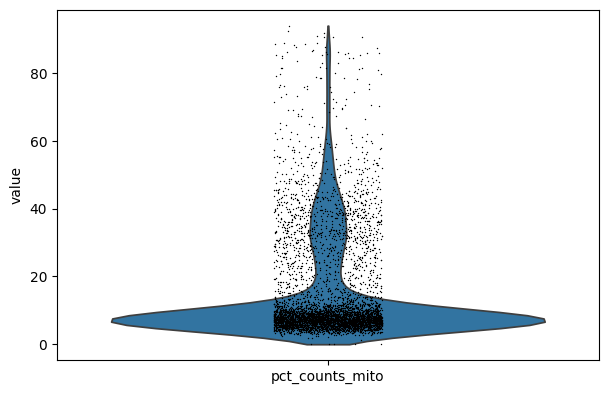

In [37]:
sc.pl.violin(pbmc5k_rna, 'pct_counts_mito') #see what the mito percent looks like

The bulk look to be under 15%, so I will set the filter to that.

In [38]:
pbmc5k_rna1 = pbmc5k_rna[pbmc5k_rna.obs.pct_counts_mito < 15, :].copy() #filter out cells where mitochondrial genes are > 20

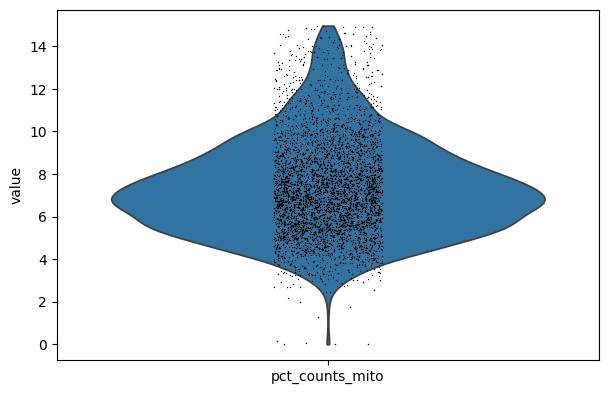

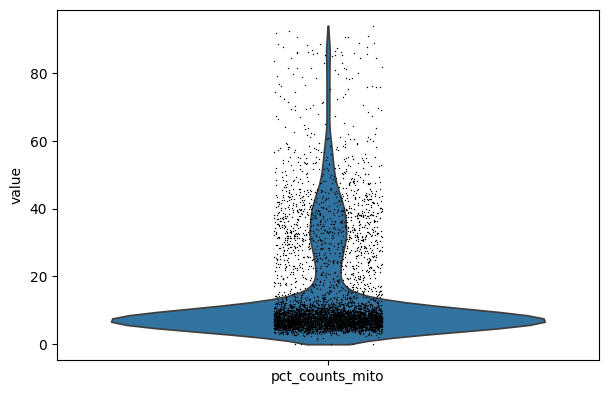

In [39]:
sc.pl.violin(pbmc5k_rna1, 'pct_counts_mito') #see what the mito percent looks like now
sc.pl.violin(pbmc5k_rna, 'pct_counts_mito')

#### Preprocess the protein object

We normalize the protein object a bit differently than the RNA object. We use sc.pp.normalize_geometric.

In [40]:
pbmc5k_protein.var["control"] = pbmc5k_protein.var_names.str.contains("control")
sc.pp.calculate_qc_metrics(
    pbmc5k_protein,
    percent_top=(5, 10, 15),
    var_type="antibodies",
    qc_vars=("control",),
    inplace=True,
)

In [41]:
pbmc5k_protein.layers["counts"] = pbmc5k_protein.X.copy() #make a copy before normalization

In [42]:
def geometric_transform(df):
    '''
    implements the scanpy transform originating from ivirshup:multimodal
    '''
    from scipy.stats.mstats import gmean
    T_geometric = np.divide(df, gmean(df + 1, axis=0))
    return T_geometric

pbmc5k_protein.X = geometric_transform(pbmc5k_protein.X.A)

In [43]:
sc.pp.log1p(pbmc5k_protein)

In [44]:
pbmc5k_rna1.write("/content/drive/MyDrive/MED263_GROUP2/data/pbmc5k_rna_preprocessed.h5ad") #write the file as a h5ad to the data directory
pbmc5k_protein.write("/content/drive/MyDrive/MED263_GROUP2/data/pbmc5k_protein_preprocessed.h5ad")

##### Performing joint integration of the scRNA and CITE-seq data on the RNA modality.

In [45]:
#!pip install scvi-tools
import scvi

In [46]:
cite_rna = sc.read("/content/drive/MyDrive/MED263_GROUP2/data/pbmc5k_rna_preprocessed.h5ad")
cite_protein = sc.read("/content/drive/MyDrive/MED263_GROUP2/data/pbmc5k_protein_preprocessed.h5ad")
sc_rna = sc.read("/content/drive/MyDrive/MED263_GROUP2/data/pbmc3k_preprocessed.h5ad")

In [47]:
cite_protein = cite_protein[cite_rna.obs.index, :] #align the protein and rna data

In [48]:
cite_rna.obsm["protein"] = cite_protein.to_df()

In [49]:
sc_rna.obs['batch'] = 'scrna'
cite_rna.obs['batch'] = 'cite'

In [50]:
combined_adata = sc.concat([cite_rna, sc_rna], merge='first')

In [51]:
scvi.model.SCVI.setup_anndata(combined_adata, layer="counts", batch_key="batch")
vae = scvi.model.SCVI(combined_adata, n_layers=2, n_latent=20, gene_likelihood="nb")
vae.train()

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 400/400: 100%|██████████| 400/400 [04:25<00:00,  1.53it/s, v_num=1, train_loss_step=4.61e+3, train_loss_epoch=4.34e+3]

INFO: `Trainer.fit` stopped: `max_epochs=400` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [04:25<00:00,  1.51it/s, v_num=1, train_loss_step=4.61e+3, train_loss_epoch=4.34e+3]


In [52]:
combined_adata.obsm["X_scVI"] = vae.get_latent_representation()
sc.pp.neighbors(combined_adata, use_rep="X_scVI")

In [53]:
sc.tl.umap(combined_adata)

In [54]:
sc.tl.leiden(combined_adata)

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


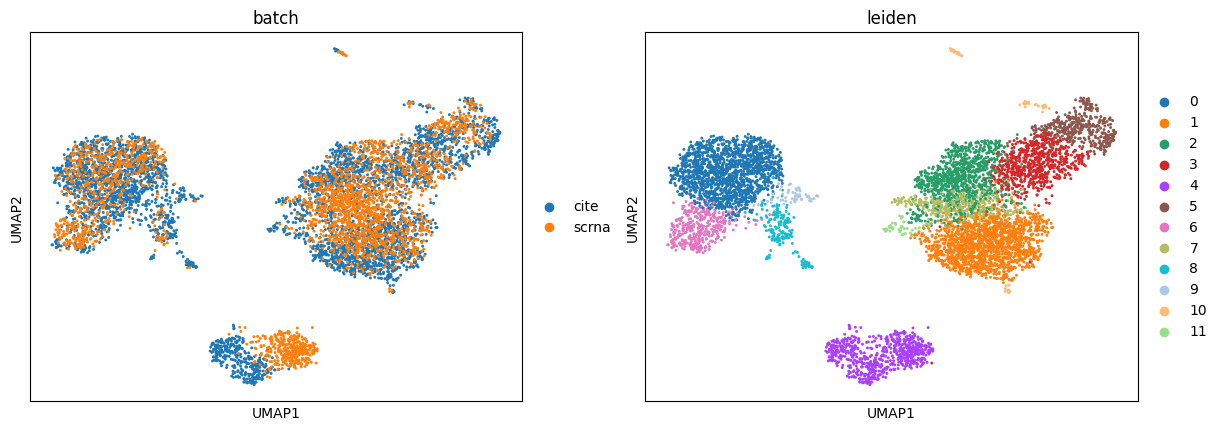

In [55]:
sc.pl.umap(combined_adata, color=["batch", "leiden"])

##### Using the integrated datasets, annotate cell types using UCell

In [56]:

# Calculate and add signatures
signatures = {
    "CD4 cell": ['CD3E', 'CD4', 'CD8A-', 'CD19-', 'IL7R'],
    "CD8 cell": ['CD3E', 'CD4-', 'CD8A+', 'CD19-', 'IL7R-', 'GZMB', 'NCAM1-', 'FCGR3A-'],
    "B cells": ['CD19', 'CD3E-', 'CD37', 'CD8A-', 'CD4-', 'ITGAX-'],
    "NK cells": ['NKG7', 'EOMES', 'NCAM1', 'CD3E-'],
    "Dendritic cells": ['ITGAX', 'XCR1', 'CD11B', 'CD11C'],
    "Monocytes": ['CD14', 'FCGR3A', 'NKG7-']
}

ucell.add_scores(combined_adata, signatures=signatures, maxRank=1000)


/usr/local/lib/python3.10/dist-packages/ucell/ucell.py:39: UserWarning: Some genes were not found in signature: Dendritic cells: ['CD11C', 'XCR1', 'CD11B']. Missing genes will be removed from the list.
  signatures = _check_signatures(signatures=signatures, indices=m.columns)


In [57]:
ucell_features = [i for i in combined_adata.obs.columns if "UCell" in i]

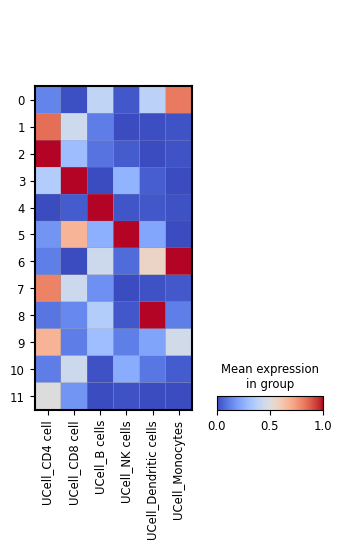

In [58]:
sc.pl.matrixplot(combined_adata, groupby='leiden', var_names=ucell_features, standard_scale='var', cmap='coolwarm')

In [59]:
cell_type_annotations = {'0': 'CD4 T cell', '1': 'Monocyte', '2':'CD4 T cell', '3':'CD8 T cell', '4': 'B cell', '5': 'NK cell', '6': 'Monocyte', '7': 'DC', '8': 'Unknown', '9': 'Unknown', '10': 'Unknown', '11': 'Unknown'}

In [60]:
combined_adata.obs['celltype'] = [cell_type_annotations.get(i) for i in combined_adata.obs['leiden']]

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


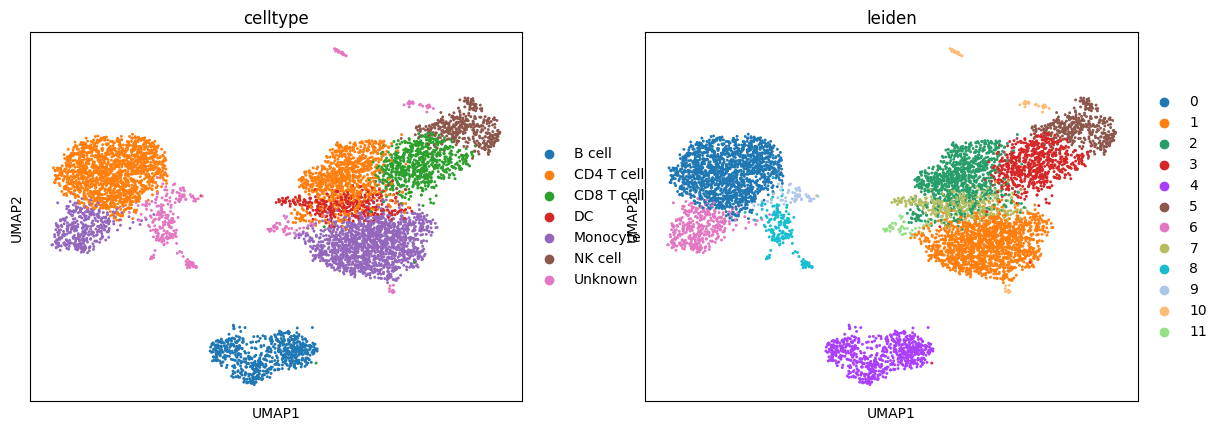

In [61]:
sc.pl.umap(combined_adata, color=["celltype", "leiden"])

In [62]:
# store integrated objects
cite_rna.obsm["X_scVI"] = combined_adata[cite_rna.obs.index].obsm["X_scVI"]
sc_rna.obsm["X_scVI"] = combined_adata[sc_rna.obs.index].obsm["X_scVI"]

cite_rna.obsm["X_umap"] = combined_adata[cite_rna.obs.index].obsm["X_umap"]
sc_rna.obsm["X_umap"] = combined_adata[sc_rna.obs.index].obsm["X_umap"]

cite_rna.obs["leiden"] = combined_adata[cite_rna.obs.index].obs["leiden"]
sc_rna.obs["leiden"] = combined_adata[sc_rna.obs.index].obs["leiden"]

cite_rna.obs["celltype"] = combined_adata[cite_rna.obs.index].obs["celltype"]
sc_rna.obs["celltype"] = combined_adata[sc_rna.obs.index].obs["celltype"]

cite_rna.write("/content/drive/MyDrive/MED263_GROUP2/data/cite_seq_integrated.h5ad")
sc_rna.write("/content/drive/MyDrive/MED263_GROUP2/data/scrna_integrated.h5ad")

# In-class tutorial starts here!

### Make sure packages are installed and imported correctly
If you didn't import the packages earlier in the code, import them now

In [63]:
import os
import scanpy as sc
import numpy as np
import pandas as pd
from scipy.spatial import KDTree
import seaborn as sns
import matplotlib.pyplot as plt
import ucell
import mygene

In [64]:
# run this block to check that your installation is successful
import pkg_resources

required_packages = {
    'numpy': '>=1.25.0',
    'pandas': '>=1.5.3',
    'scanpy': '>=1.9.8',
    'scrublet': '>=0.2.3',
    'scvi-tools': '>=1.1.2',
    'matplotlib': '>=3.7.1',
    'ucell': '>=0.1',
    'seaborn': '>=0.13.0',
    'mygene': '>=3.2.2',
}

for package, version_range in required_packages.items():
    try:
        installed_version = pkg_resources.get_distribution(package).version
        version_requirement = pkg_resources.Requirement.parse(f"{package}{version_range}")
        assert pkg_resources.parse_version(installed_version) in version_requirement, \
            f"{package} version must be within {version_range}, found version {installed_version}"
    except pkg_resources.DistributionNotFound:
        assert False, f"{package} is not installed."

print("All required packages are installed and within the specified version ranges.")

All required packages are installed and within the specified version ranges.


#### Use KNN to impute protein expression values

In [65]:
## read in the integrated scanpy objects that we have pre calculated
cite_rna = sc.read_h5ad('/content/drive/MyDrive/MED263_GROUP2/data/cite_seq_integrated.h5ad')
sc_rna = sc.read_h5ad('/content/drive/MyDrive/MED263_GROUP2/data/scrna_integrated.h5ad')

In [66]:
# Ensure the joint latent space is present and aligned
assert 'X_scVI' in cite_rna.obsm.keys(), "X_scvi not found in CITE-seq object"
assert 'X_scVI' in sc_rna.obsm.keys(), "X_scvi not found in scRNA-seq object"

In [67]:
#find the nearest cite seq neighbor cells of each scRNA cell using the 'X_scVI' latent space
kdtree = KDTree(cite_rna.obsm['X_scVI'])
distances, indices = kdtree.query(sc_rna.obsm['X_scVI'], k=30)

In [68]:
# Initialize a place to store imputed values for the scRNA-seq dataset
num_proteins = cite_rna.obsm['protein'].shape[1]
imputed_proteins = np.zeros((sc_rna.shape[0], num_proteins)) # Assuming protein expression is stored here

In [69]:
# Impute protein expression for each scRNA-seq cell based on CITE-seq neighbors
for cell_idx in range(sc_rna.shape[0]):  # Iterate through scRNA-seq cells
    imputed_proteins[cell_idx] = np.mean(cite_rna[indices[cell_idx]].obsm['protein'], axis=0)


In [70]:
# Add the imputed protein expression to the scRNA-seq AnnData object
sc_rna.obsm['imputed_protein_expression'] = imputed_proteins

#### plot imputed protein level on scRNA

In [71]:
# add each protein to the scrna adata
protein_names = list(cite_rna.obsm['protein'].columns)
for i, protein in enumerate(protein_names):
    # Extract the protein expression values from .obsm and add to .obs for plotting
    sc_rna.obs[protein] = sc_rna.obsm['imputed_protein_expression'][:, i]

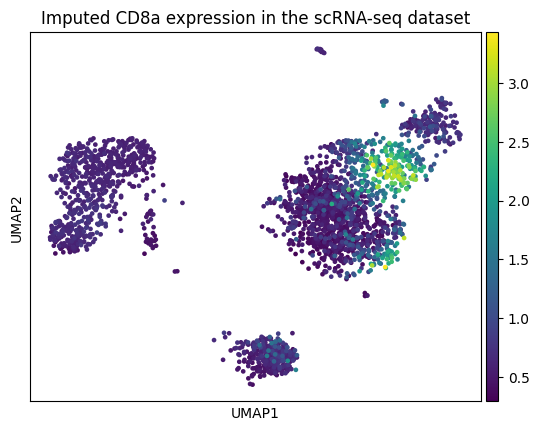

In [72]:
# plot imputed CD8a protein expression as an example using sc.pl.umap
protein = 'CD8a_TotalSeqB'
sc.pl.umap(sc_rna, color=protein,
           title=f"Imputed {protein.split('_')[0]} expression in the scRNA-seq dataset")

In [73]:
# save the result
sc_rna.write("/content/drive/MyDrive/MED263_GROUP2/data/scrna_integrated_imputed.h5ad")

## Plotting coexpression between RNA and protein

In [74]:
sc_rna = sc.read("/content/drive/MyDrive/MED263_GROUP2/data/scrna_integrated_imputed.h5ad")
cite_rna = sc.read("/content/drive/MyDrive/MED263_GROUP2/data/cite_seq_integrated.h5ad")

In [75]:
# string processing for the protein name
protein_names = [i.split('_')[0].upper() for i in cite_rna.obsm['protein'].columns]

In [76]:
import mygene

# Initialize a MyGeneInfo object
mg = mygene.MyGeneInfo()

# List of gene symbols or IDs for which you want to retrieve aliases
genes = protein_names

gene_aliases = []
# Querying MyGene.info for aliases
for g in genes:
    query_list = mg.query(g)['hits']
    try:
        symbols = [j['symbol'].upper() for j in query_list]
        symbols_in = [sym for sym in symbols if sym in cite_rna.var.index.values]
        gene_aliases.append(symbols_in)
    except:
        gene_aliases.append([])

In [77]:
overlapping_names = [i[0] if len(i) > 0 else '' for i in gene_aliases]

##### Specify which gene to plot protein vs rna

In [78]:
gene_to_plot = overlapping_names[2]

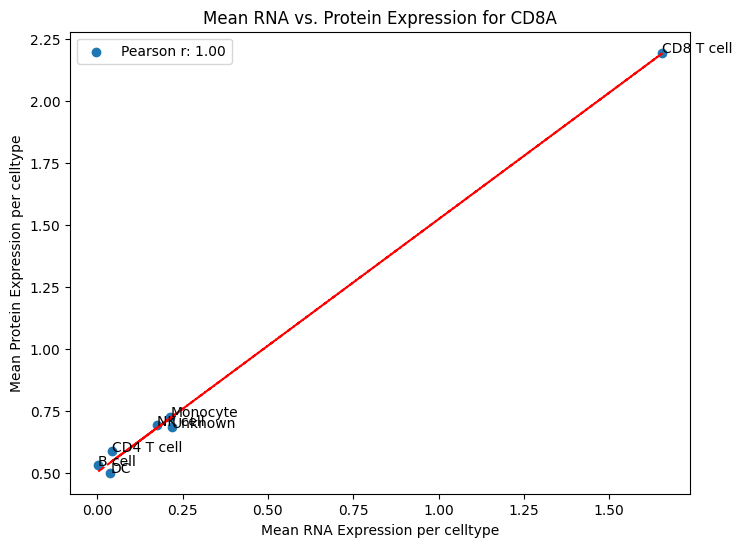

In [79]:
correlation_coefficients = []
gene_names = []

for i, e in enumerate(overlapping_names):
    if e != '':
        # Extract RNA and protein expressions
        rna_expression = cite_rna[:, cite_rna.var.index == e].X.toarray().flatten()
        protein_expression = cite_rna.obsm['protein'][cite_rna.obsm['protein'].columns[i]].values

        # Create a DataFrame with RNA, protein expressions, and cell type
        df = pd.DataFrame({'rna': rna_expression, 'protein': protein_expression, 'celltype': cite_rna.obs['celltype']})

        # Group by cell type and calculate the mean
        group_means = df.groupby('celltype').mean()

        # Calculate Pearson correlation coefficient
        corr_coef = np.corrcoef(group_means['rna'], group_means['protein'])[0, 1]

        correlation_coefficients.append(corr_coef)
        gene_names.append(e)

        if e == gene_to_plot:
            # Plotting
            plt.figure(figsize=(8, 6))
            plt.scatter(group_means['rna'], group_means['protein'], label=f'Pearson r: {corr_coef:.2f}')

            # Line of best fit
            m, b = np.polyfit(group_means['rna'], group_means['protein'], 1)
            plt.plot(group_means['rna'], m * group_means['rna'] + b, 'r--')

            # Annotate each point with cell type
            for j, txt in enumerate(group_means.index):
                plt.annotate(txt, (group_means['rna'][j], group_means['protein'][j]))

            plt.title(f"Mean RNA vs. Protein Expression for {e}")
            plt.xlabel('Mean RNA Expression per celltype')
            plt.ylabel('Mean Protein Expression per celltype')
            plt.legend()
            plt.grid(False)
            plt.show()


##### Which genes have highly correlated protein and RNA expression?

In [80]:
whole_df = pd.DataFrame(correlation_coefficients, index=gene_names, columns=['correlation']).sort_values(by='correlation', ascending=False)

Text(0.5, 1.0, 'Cross-Celltype Correlation Coefficients between RNA and Protein Expression')

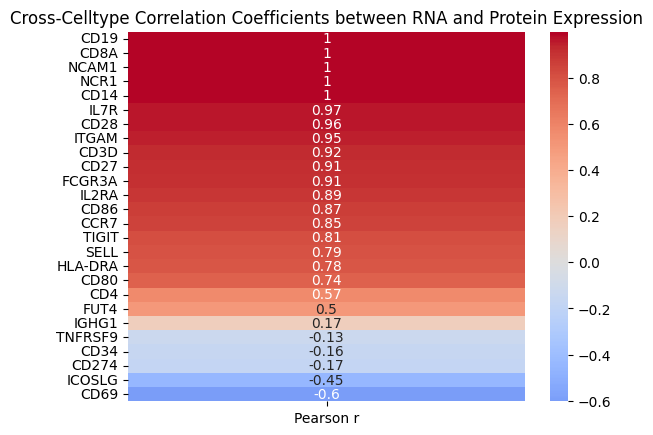

In [81]:

sns.heatmap(whole_df, annot=True, yticklabels=whole_df.index, xticklabels=['Pearson r'], cmap='coolwarm', center=0)
plt.title('Cross-Celltype Correlation Coefficients between RNA and Protein Expression')